In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import FunctionTransformer

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.impute import SimpleImputer

from sklearn.metrics import recall_score

from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [5]:
## printing the shape and head
def head(df,shape_only=False):
    print(df.shape)

    if shape_only:
        return
    else:
        return df.head()

## for EDA of categorical values
def eda_bivariate_categorical(df,column,target):

    fig,ax = plt.subplots(figsize = (9,8))

    color = 'Set2'

    palette_color = sns.color_palette(color)

    ax = sns.countplot(x = column, data=df, hue=target,palette=color,order = df[column].value_counts().index)
    ax.set_ylabel('Count')

    offset = df[column].value_counts().max() * 0.005

    list_bars = df.groupby([column,target])[column].agg(['count']).unstack().fillna(0).values

    patches = ax.patches
    bars_pos = 0

    for i in range(df[target].nunique()):
        for j in range(df[column].nunique()):
            list_bars_col = list_bars[j] 
            total_sum = list_bars_col.sum()
            value = list_bars_col[i]

            percentage = value / total_sum

            if percentage == 0:
                bars_pos += 1
                continue
            else:
                x = patches[bars_pos].get_x() + patches[j].get_width()/2
                y = patches[bars_pos].get_height() + offset
                ax.annotate('{:.1f}%'.format(percentage*100), (x, y), ha='center')
                bars_pos += 1
    plt.show()

## Function that plots numerical variables into histogram and violin plot
def eda_bivariate_numerical(data,column,target,color,
                    figsize=(12,6),
                    # save=True,
                    val=0,
                    target_type = 'Numerical'):

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    cmap = sns.color_palette(color)
    val = val

    for i in range(1):
        for j in range(2):
            if j==0:
                    sns.histplot(data = data,x=data[column],hue=target,
                                bins=50,kde=True,palette=color,ax=axes[j])
                    axes[j].set(xlabel=None)
                    axes[j].grid(False)
            elif j==1:
                sns.boxplot(data = data,x=data[column],y = target, ax=axes[j], palette=color,orient='h',
                )
                axes[j].set(xlabel=None)
                axes[j].grid(False)
                val += 1
                plt.tight_layout()
            if target_type == 'Numerical':
                plt.suptitle(column)
            else:
                plt.suptitle(f'{column} vs. {target}')
    plt.show()
    
    # path = 'Figures\\Numerical\\'
    # if save:
    #     plt.savefig(f"{path}{column}.pdf",dpi=1000)


## print text to see the font
def print_text(text):
    fig, ax = plt.subplots(figsize=(6, 1), facecolor="#eefade")
    ax.text(0.5, 0.5, text, ha='center', va='center', size=40)
    ax.axis("off")
    plt.show()

In [6]:
df = pd.read_csv('/kaggle/input/cardiovascular-diseases-risk-prediction-dataset/CVD_cleaned.csv')

## Viewing the dataframe and shape
head(df,shape_only=False) 

(308854, 19)


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [7]:
target = 'Heart_Disease'

In [8]:
## Creating numerical and categorical columns
numerical = df.select_dtypes(include=['float64']).columns.sort_values()
categorical = df.select_dtypes(include=['object']).columns.sort_values()

## Printing the length of numerical and categorical. The total length should have
## the same length as our dataframe
print(f'There are {len(categorical)} Categorical variables')
print(f'There are {len(numerical)} Numerical variables')

There are 12 Categorical variables
There are 7 Numerical variables


In [9]:
## Showing the columns in alphabetical order
df.columns.sort_values()

## Showing the descriptions of numerical variables
print('')
num_describe = df.describe().T
num_describe_table = num_describe.loc[:,['mean', 'std', '25%', '50%', '75%']]
print(num_describe_table)

## Showing the descriptions of categorical variables
print('')
object_describe_table = df.describe(include=object)
print(object_describe_table)
## print it to latex
# print(object_describe_table.to_latex())


                                    mean        std     25%     50%     75%
Height_(cm)                   170.615249  10.658026  163.00  170.00  178.00
Weight_(kg)                    83.588655  21.343210   68.04   81.65   95.25
BMI                            28.626211   6.522323   24.21   27.44   31.85
Alcohol_Consumption             5.096366   8.199763    0.00    1.00    6.00
Fruit_Consumption              29.835200  24.875735   12.00   30.00   30.00
Green_Vegetables_Consumption   15.110441  14.926238    4.00   12.00   20.00
FriedPotato_Consumption         6.296616   8.582954    2.00    4.00    8.00

       General_Health               Checkup Exercise Heart_Disease  \
count          308854                308854   308854        308854   
unique              5                     5        2             2   
top         Very Good  Within the past year      Yes            No   
freq           110395                239371   239381        283883   

       Skin_Cancer Other_Cancer Depress

In [10]:
params = {'font.size' : 14,
          'font.family' : 'Libre Caslon Text',
          }
plt.rcParams.update(params)

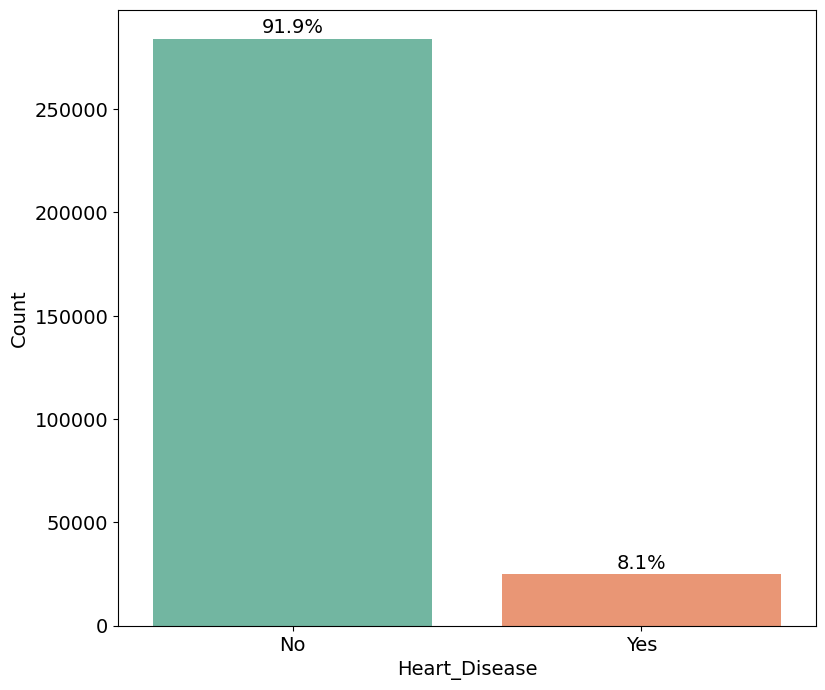

In [11]:
fig,ax = plt.subplots(figsize = (9,8))
color = 'Set2'
palette_color = sns.color_palette(color)

ax = sns.countplot(x = target, 
                data=df,
                palette=color,
                order = df[target].value_counts().index
                )
ax.set_ylabel('Count')

patches = ax.patches

for j in range(len(patches)):
        percentage = list(df[target].value_counts())[j]/df[target].value_counts().sum()
        offset = df[target].value_counts().max() * 0.01
        x = patches[j].get_x() + patches[j].get_width()/2
        y = patches[j].get_height() + offset
        ax.annotate('{:.1f}%'.format(percentage*100), (x, y), ha='center')

plt.show()

General_Health


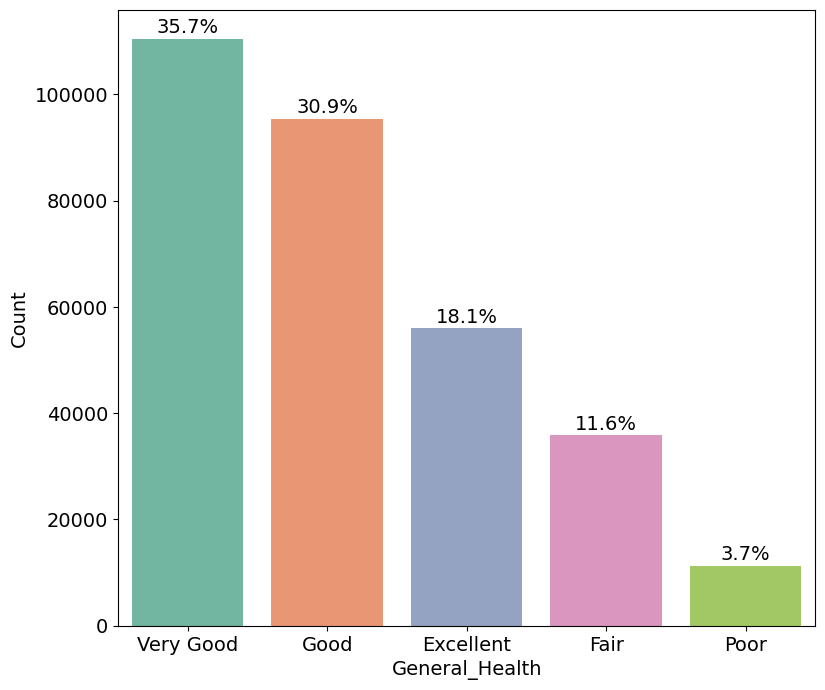

Checkup


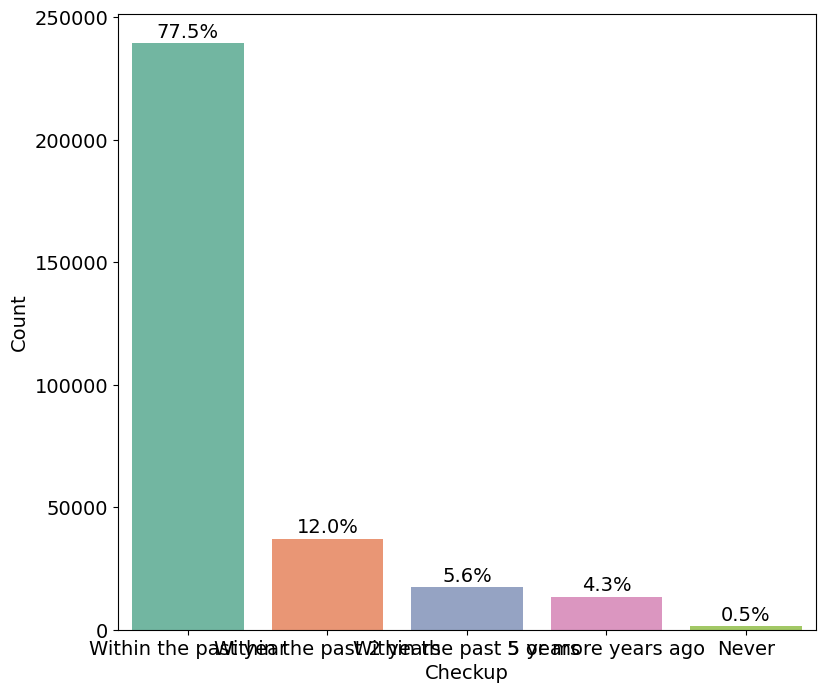

Exercise


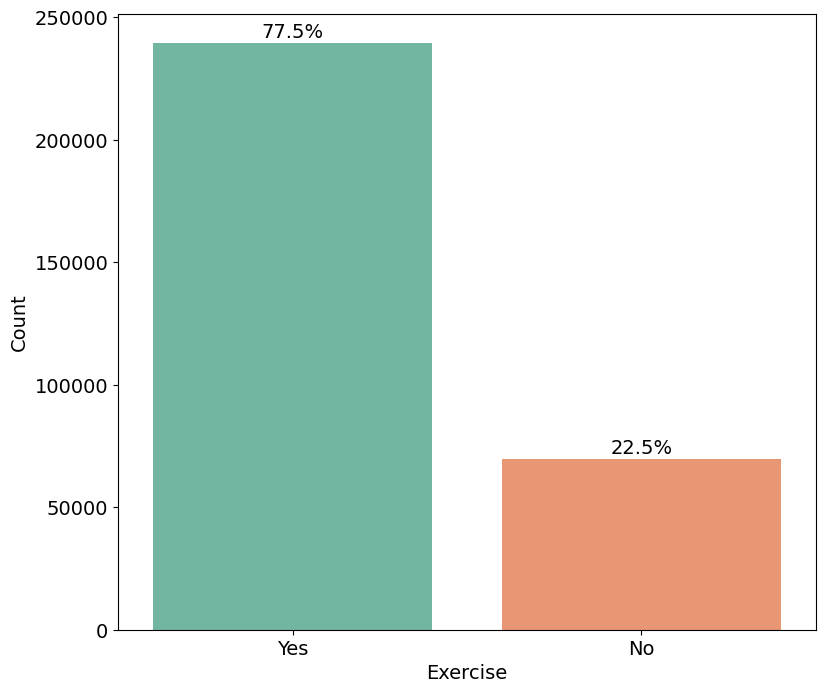

Skin_Cancer


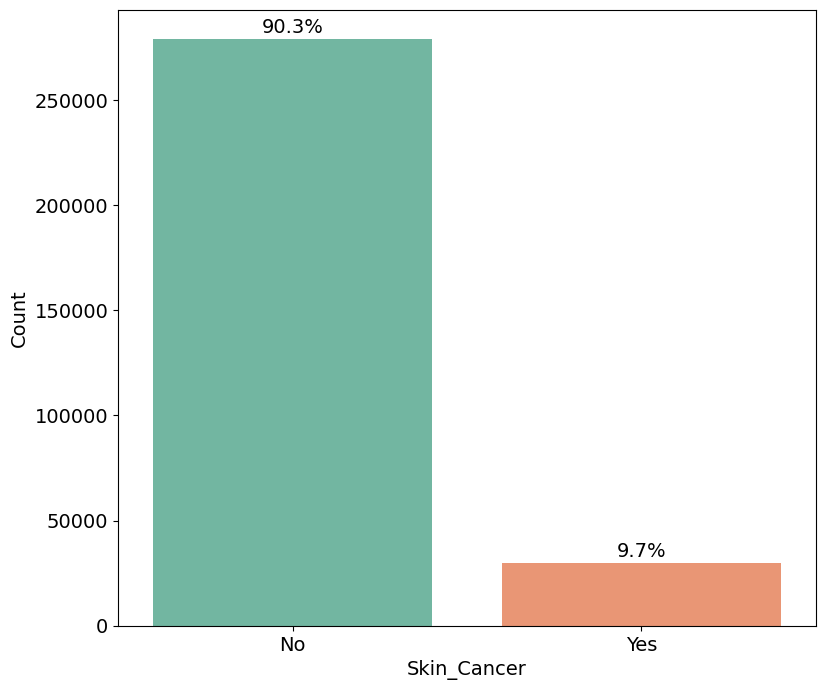

Other_Cancer


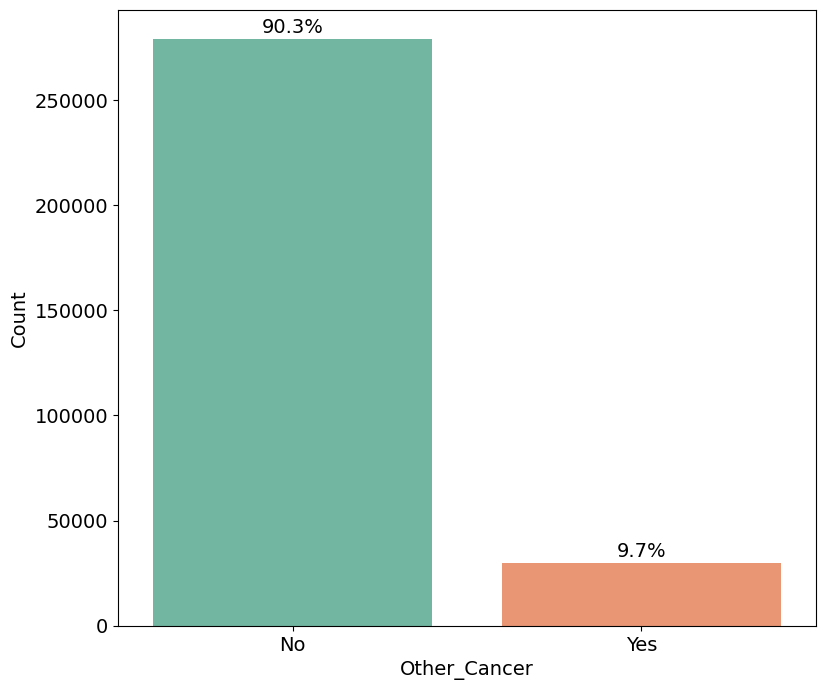

Depression


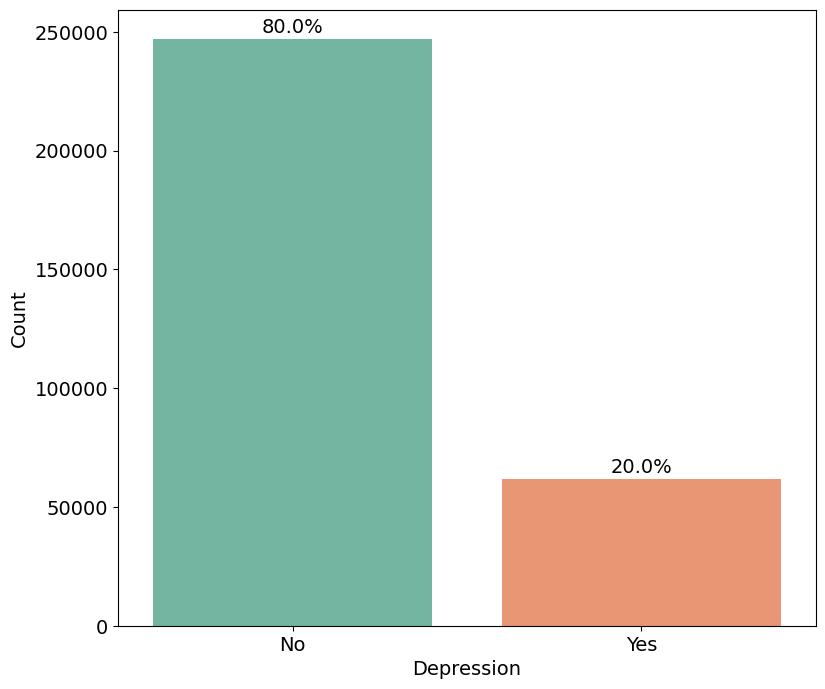

Diabetes


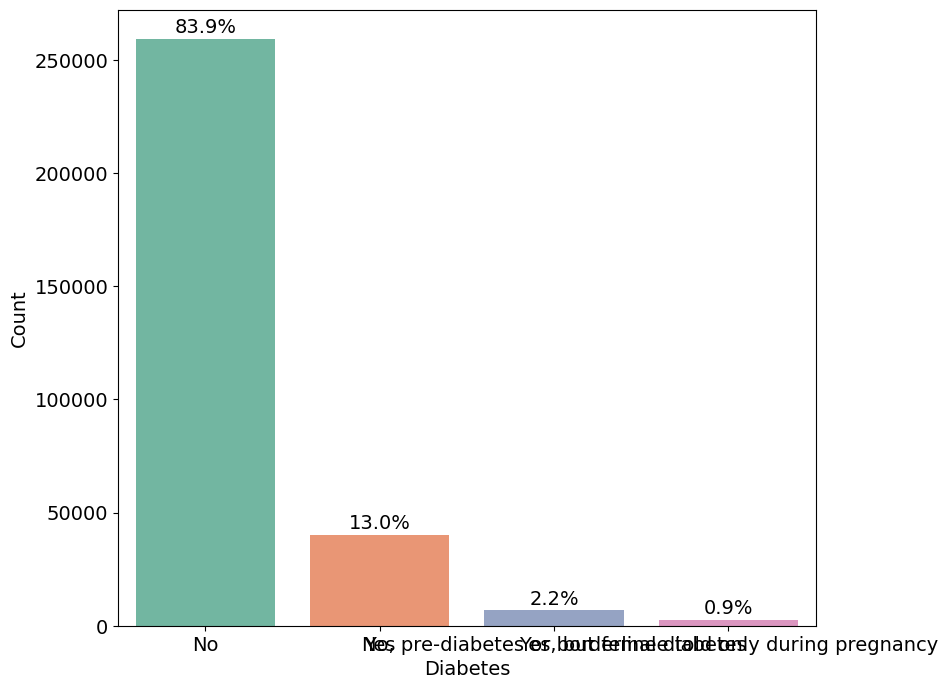

Arthritis


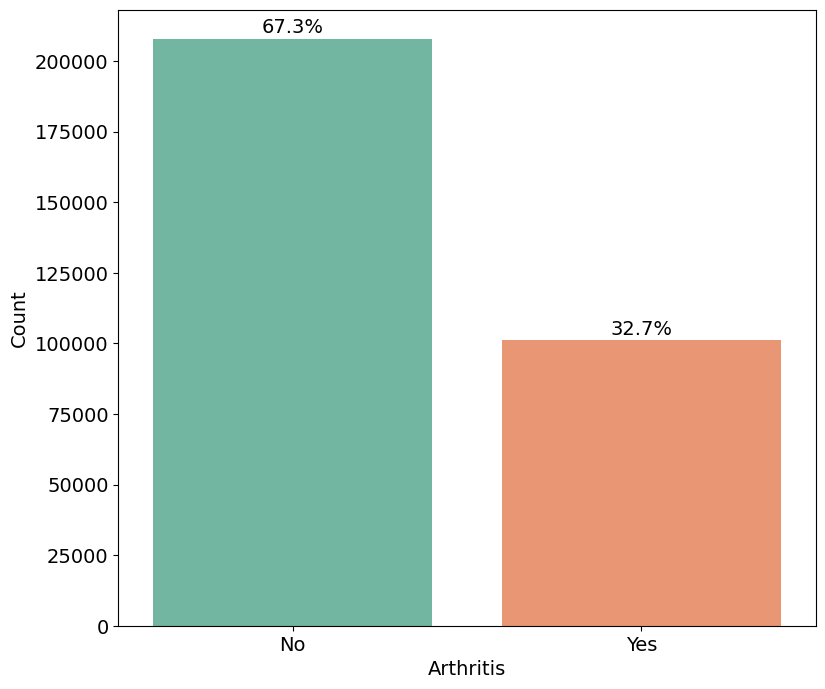

Sex


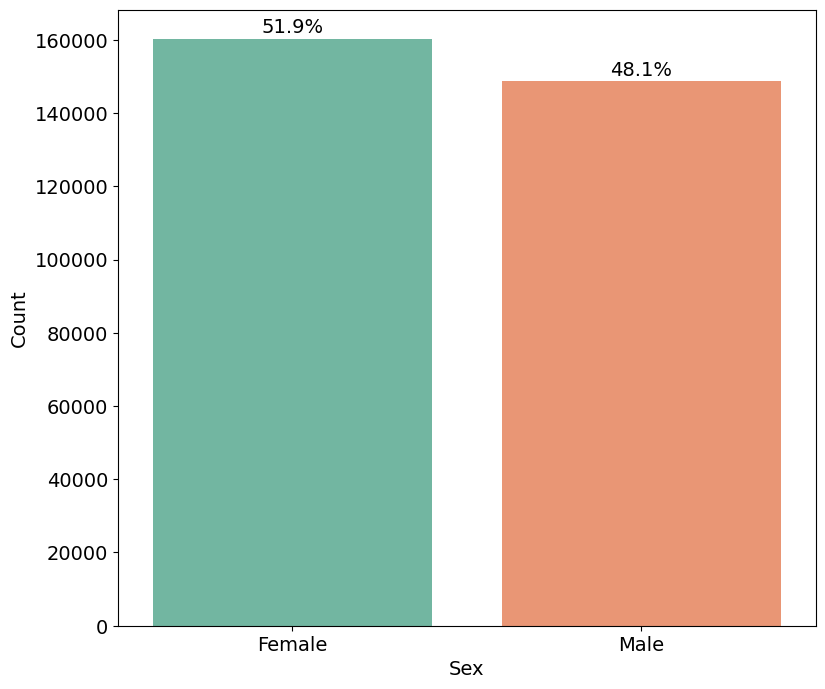

Age_Category


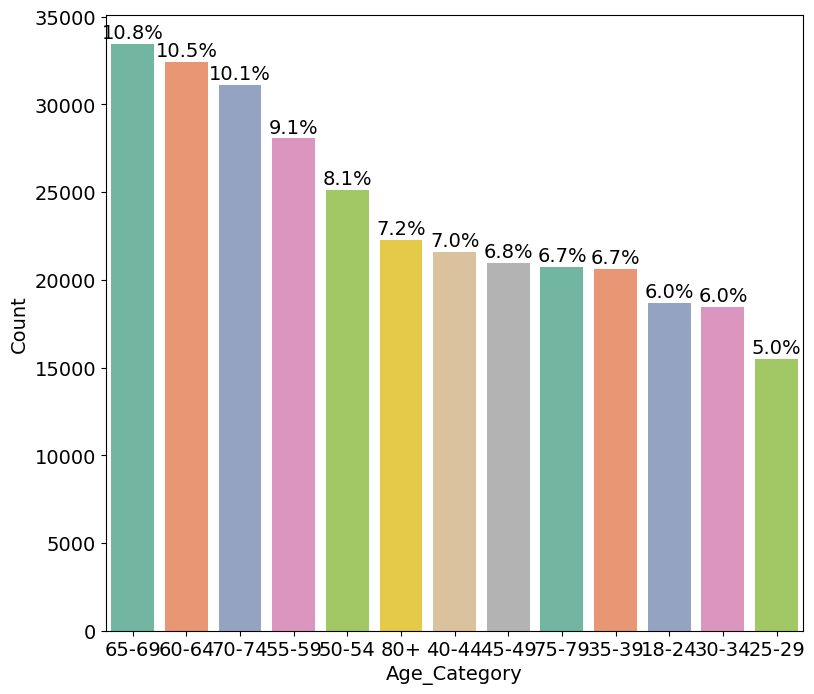

Height_(cm)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


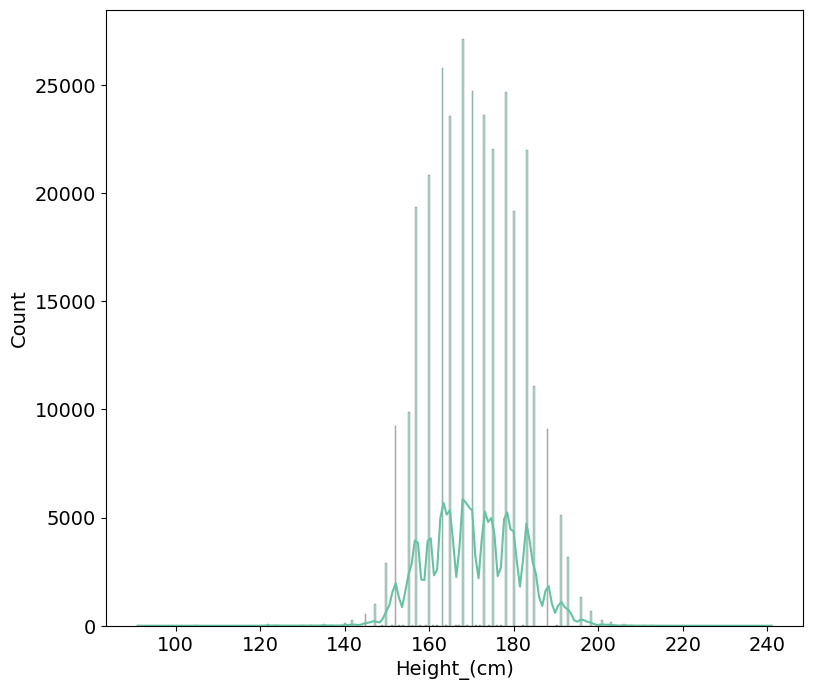

Weight_(kg)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


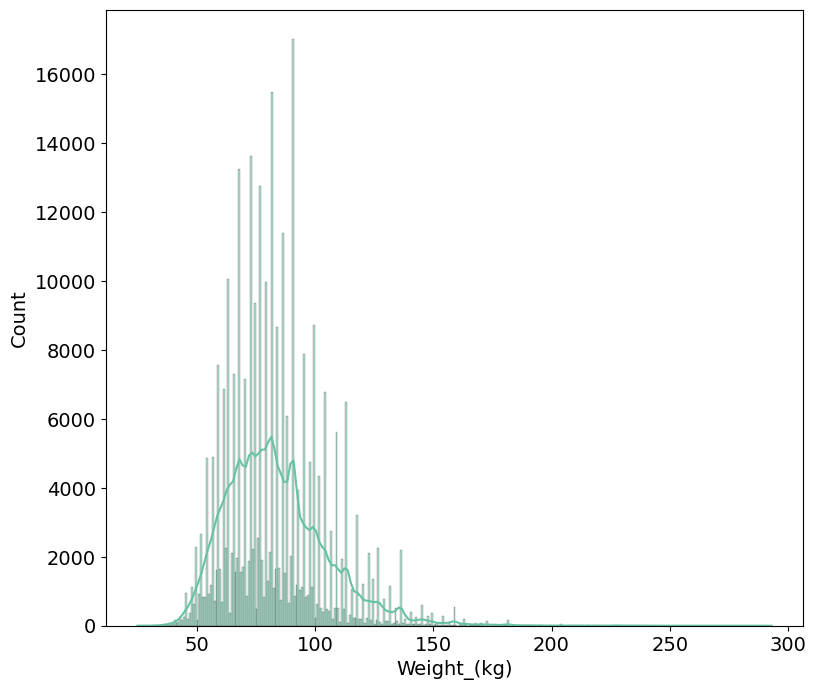

BMI


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


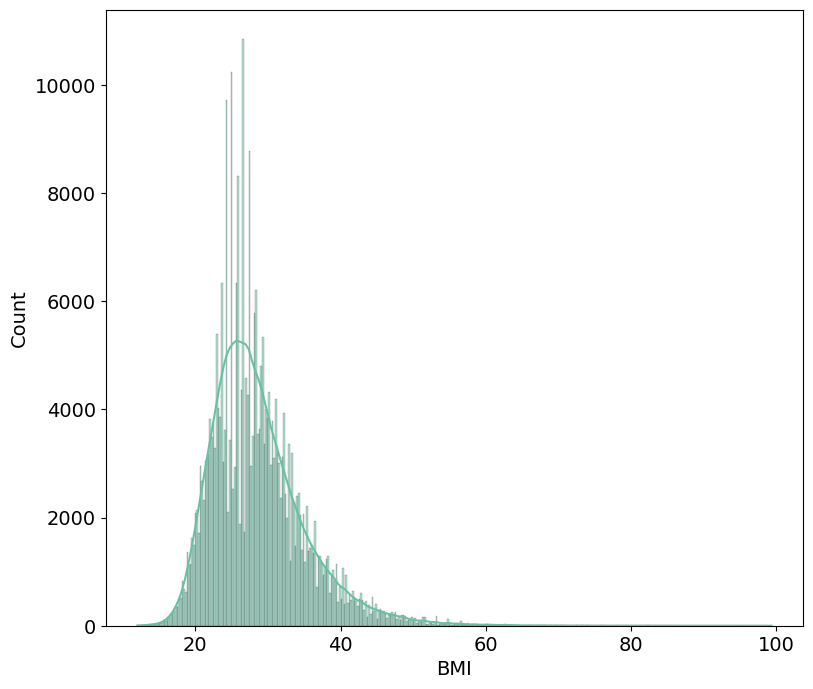

Smoking_History


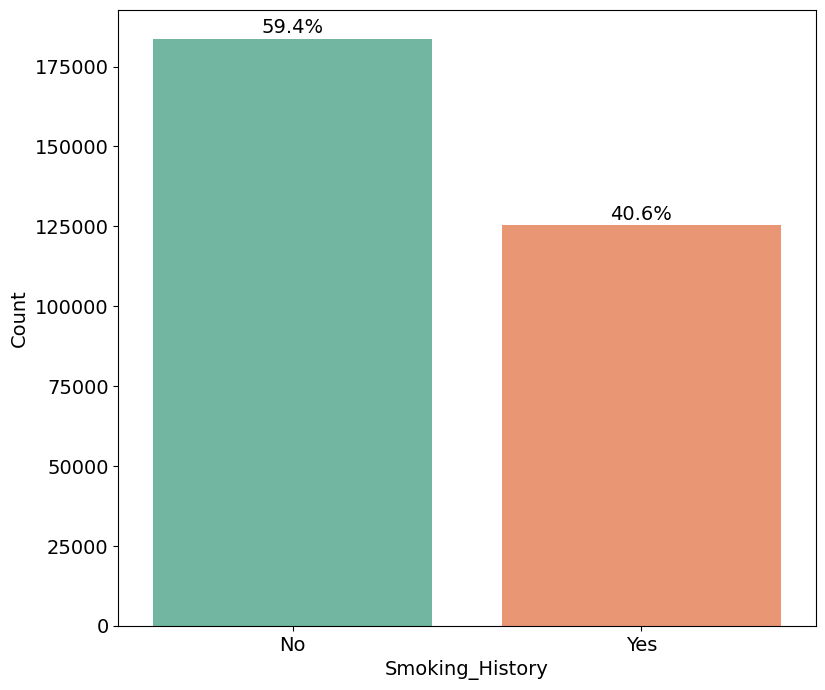

Alcohol_Consumption


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


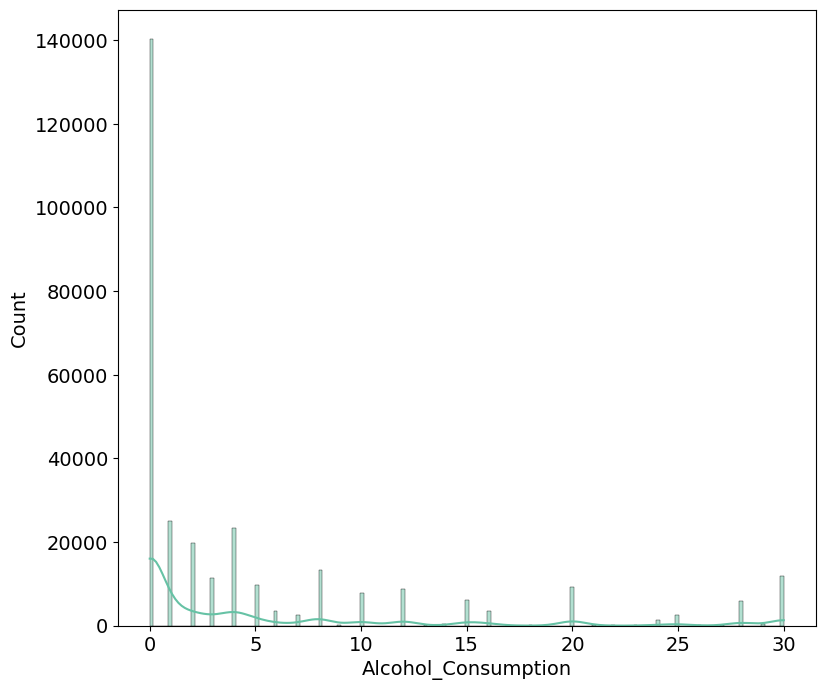

Fruit_Consumption


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


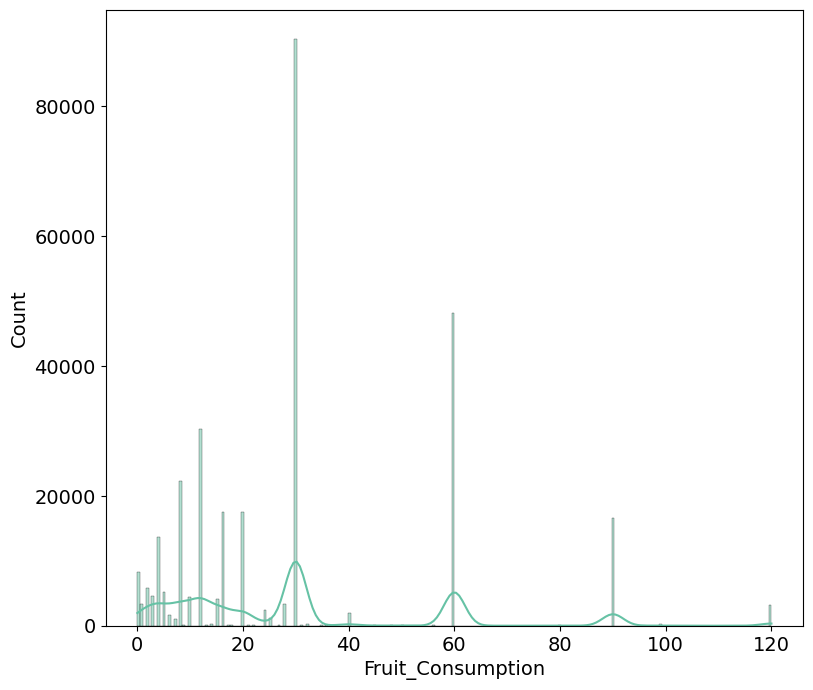

Green_Vegetables_Consumption


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


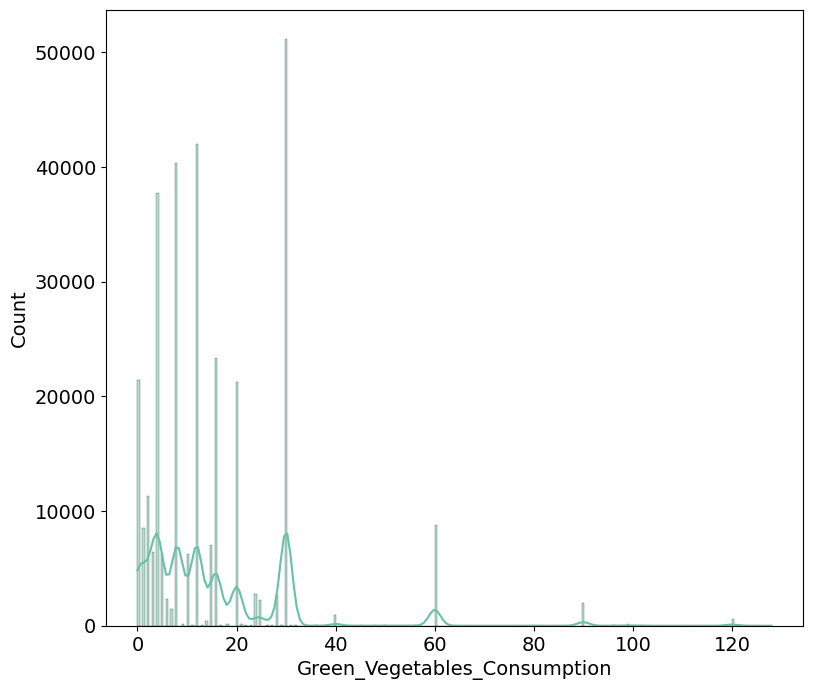

FriedPotato_Consumption


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


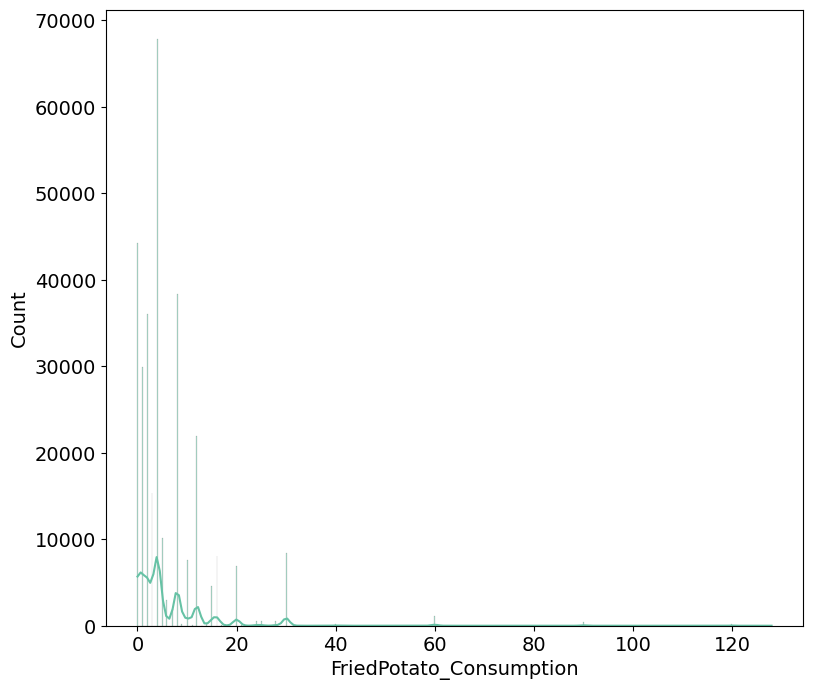

In [12]:
for i in df.columns:
    
    if i == target:
        continue

    if i in categorical:
        if df[i].nunique() > 15:
            print(f'column {i} has many unique values n = {df[i].nunique()} and will not be plotted')
            print('=======================================================')
            continue
        else:
            print(f'{i}')
            fig,ax = plt.subplots(figsize = (9,8))
            color = 'Set2'
            palette_color = sns.color_palette(color)
            ax = sns.countplot(x = i, 
                data=df,
                palette=color,
                order = df[i].value_counts().index
                )
            ax.set_ylabel('Count')

            patches = ax.patches

            for j in range(len(patches)):
                # list_unq_val = list(df[i].unique())

                # cleaned = [x for x in list_unq_val if str(x) != 'nan']
                offset = df[i].value_counts().max() * 0.01
                percentage = list(df[i].value_counts())[j]/df[i].value_counts().sum()
                x = patches[j].get_x() + patches[j].get_width()/2
                y = patches[j].get_height()+ offset
                ax.annotate('{:.1f}%'.format(percentage*100), (x, y), ha='center')
                
            plt.show()
            print('=======================================================')
    
    elif i in numerical:
        print(f'{i}')
        fig,ax = plt.subplots(figsize = (9,8))
        color = 'Set2'
        palette_color = sns.color_palette(color)
        ax = sns.histplot(x = i, 
                data=df,
                # bins = 'auto',
                # bins = 50,
                kde = True,
                color=palette_color[0],
                )
        ax.set_ylabel('Count')
        plt.show()
        print('=======================================================')

Age_Category vs. Heart_Disease


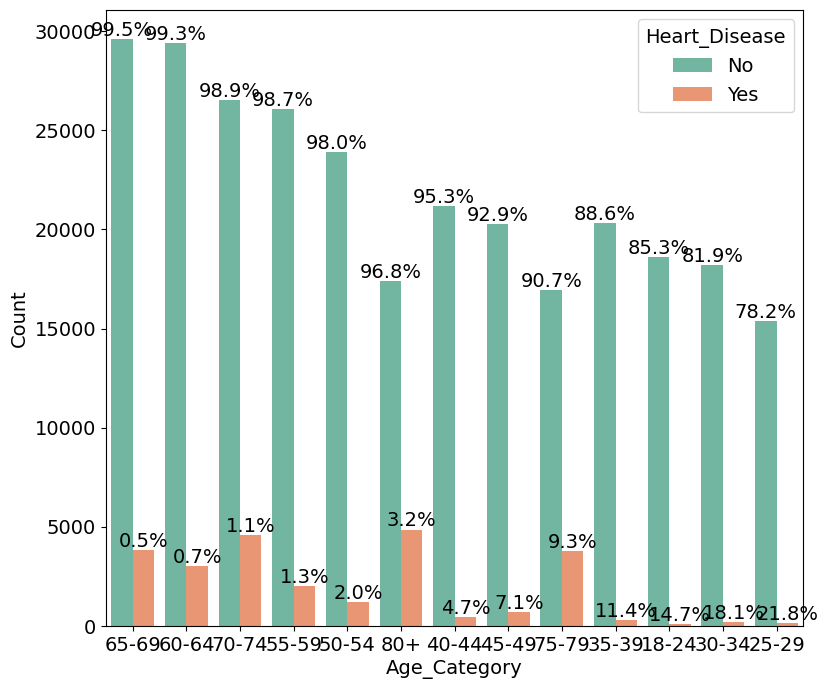

Arthritis vs. Heart_Disease


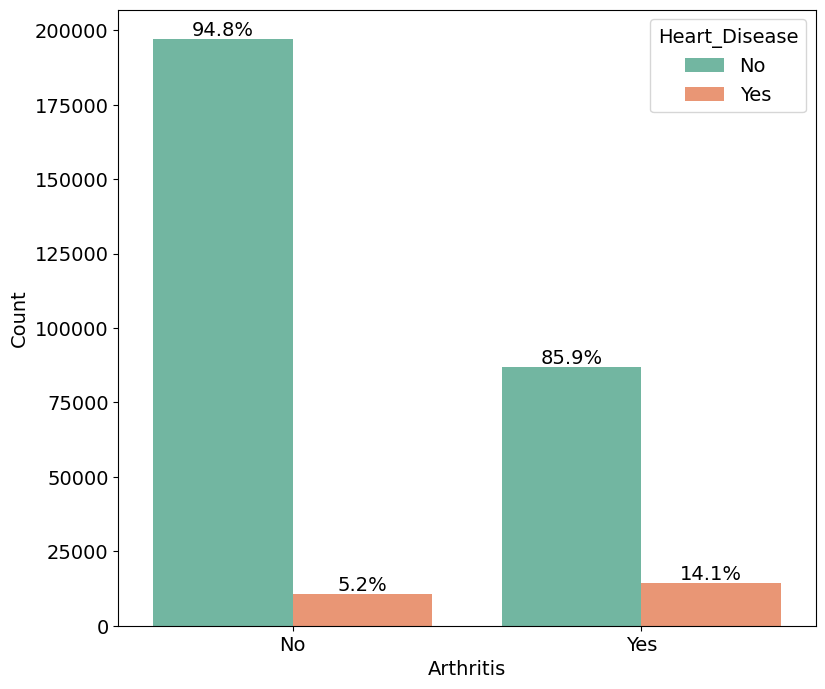

Checkup vs. Heart_Disease


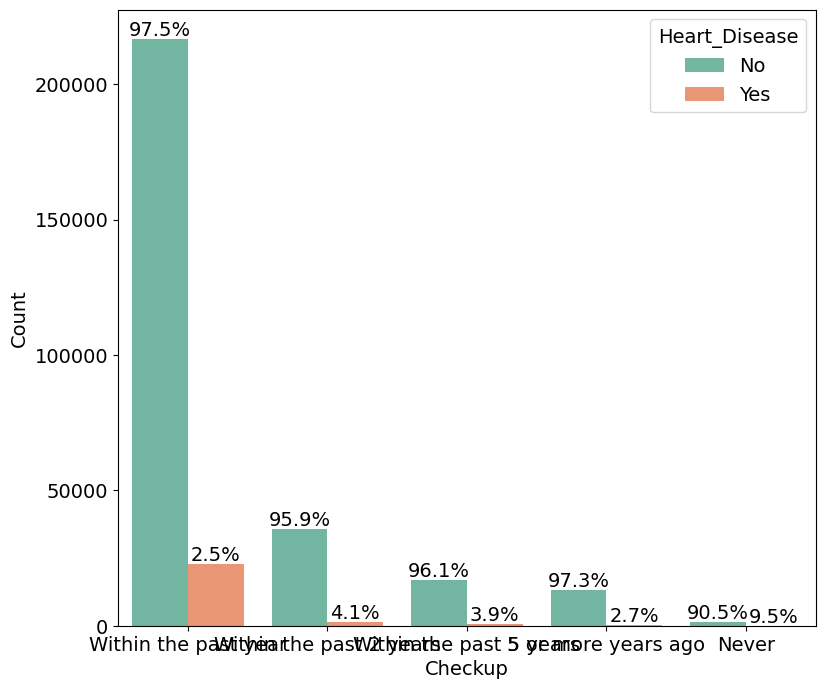

Depression vs. Heart_Disease


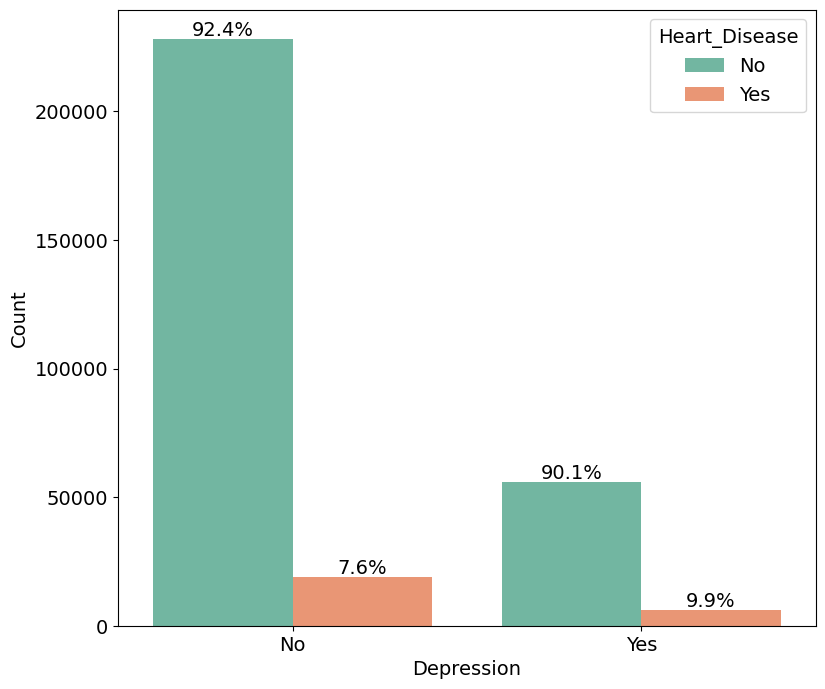

Diabetes vs. Heart_Disease


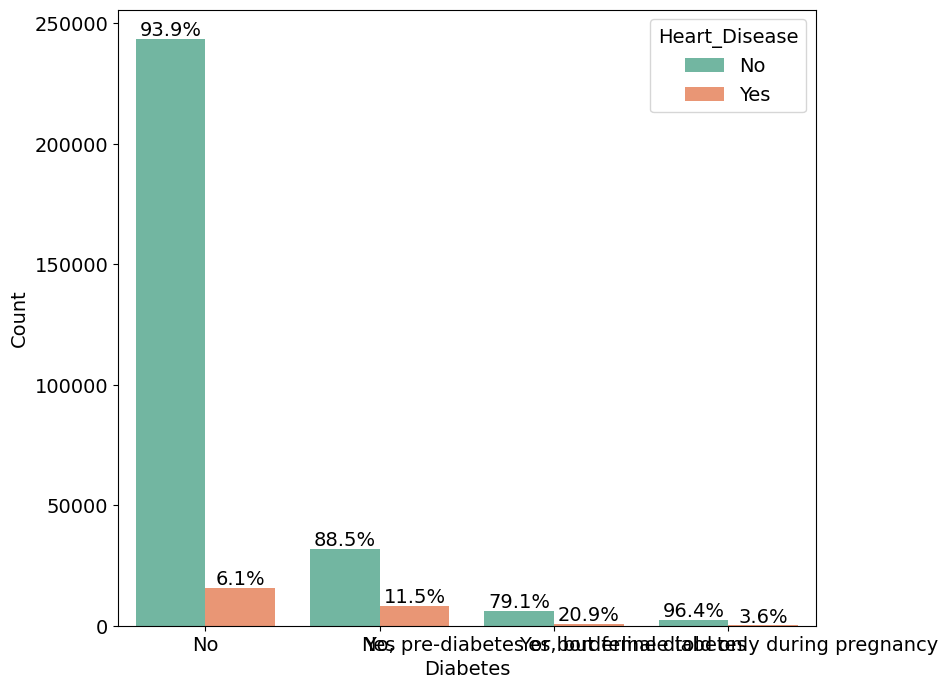

Exercise vs. Heart_Disease


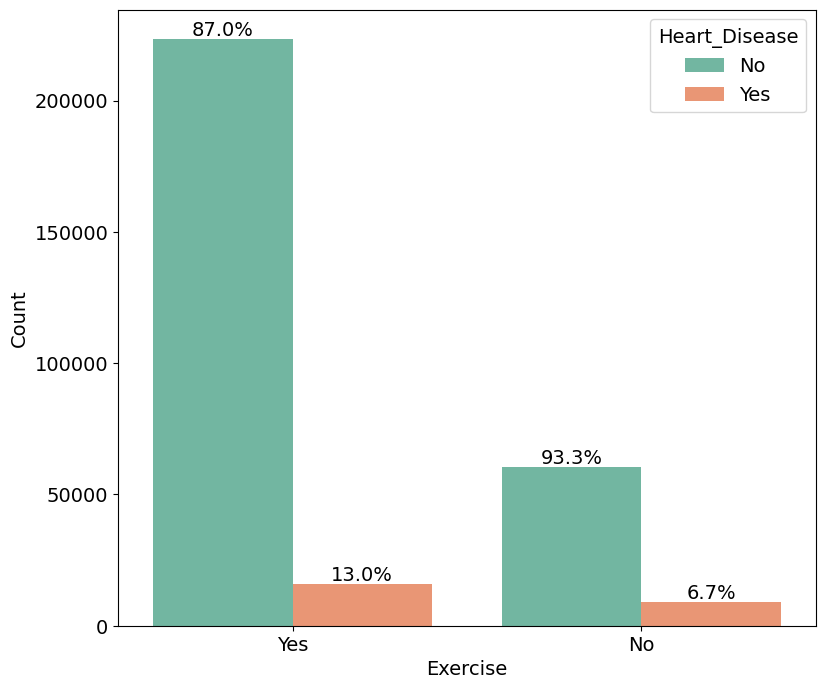

General_Health vs. Heart_Disease


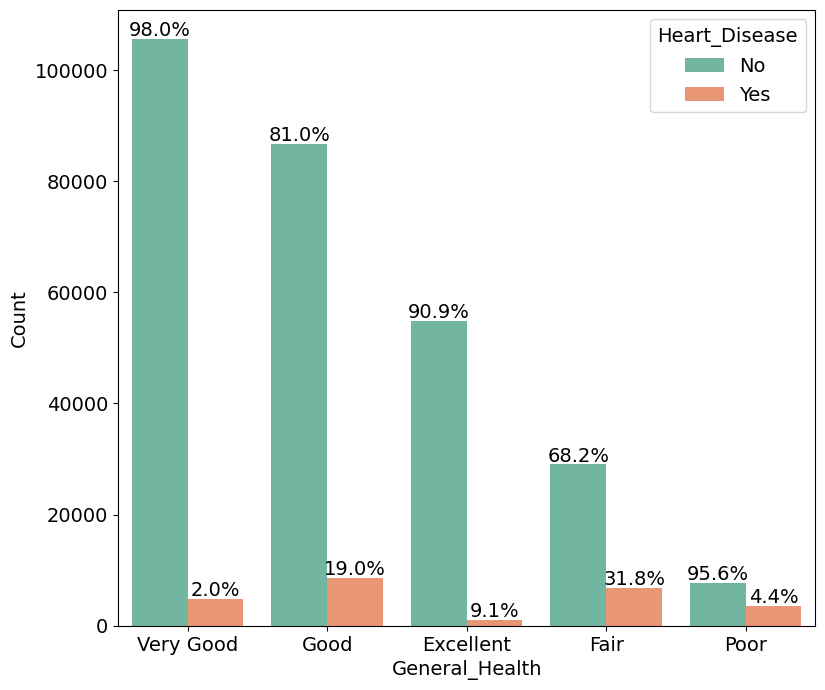

Other_Cancer vs. Heart_Disease


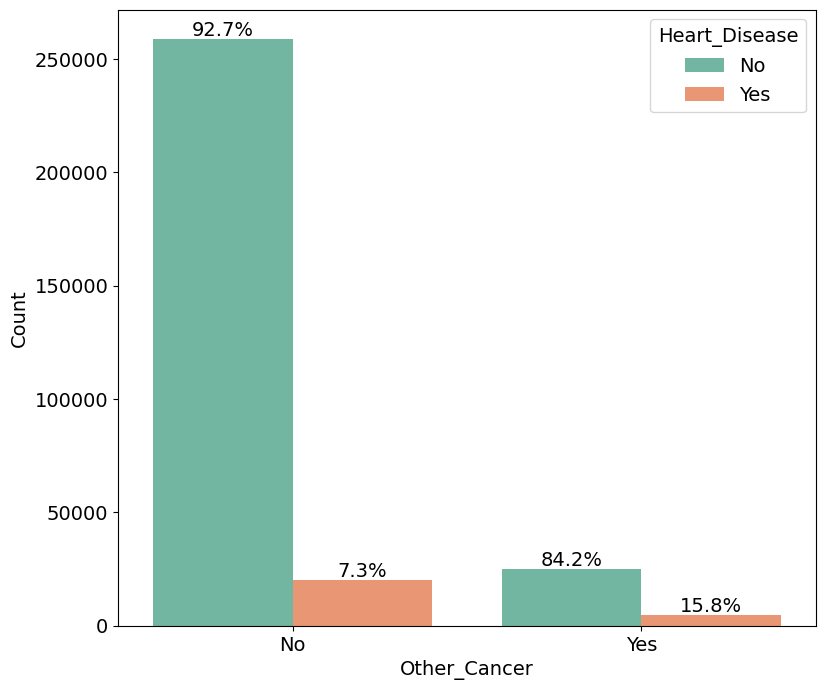

Sex vs. Heart_Disease


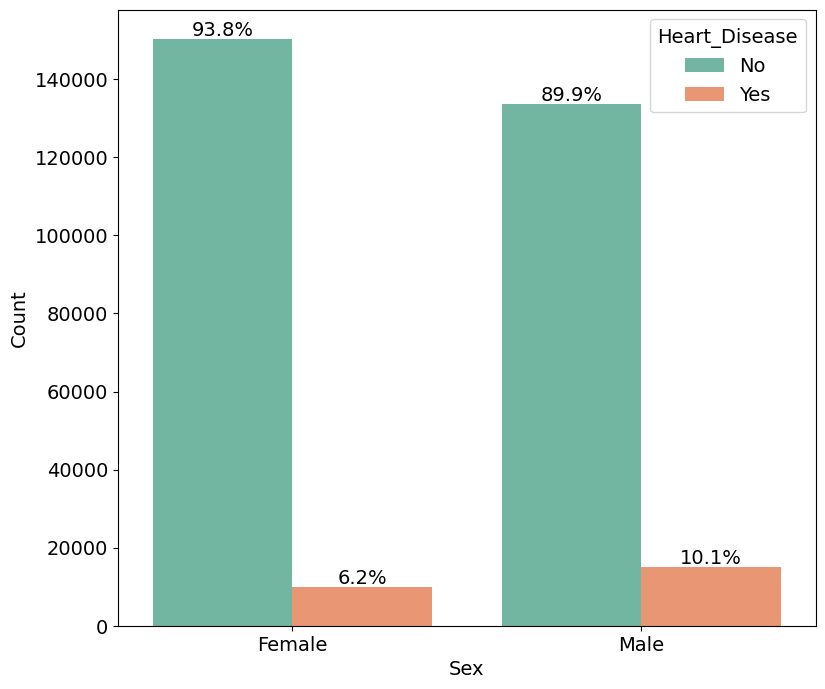

Skin_Cancer vs. Heart_Disease


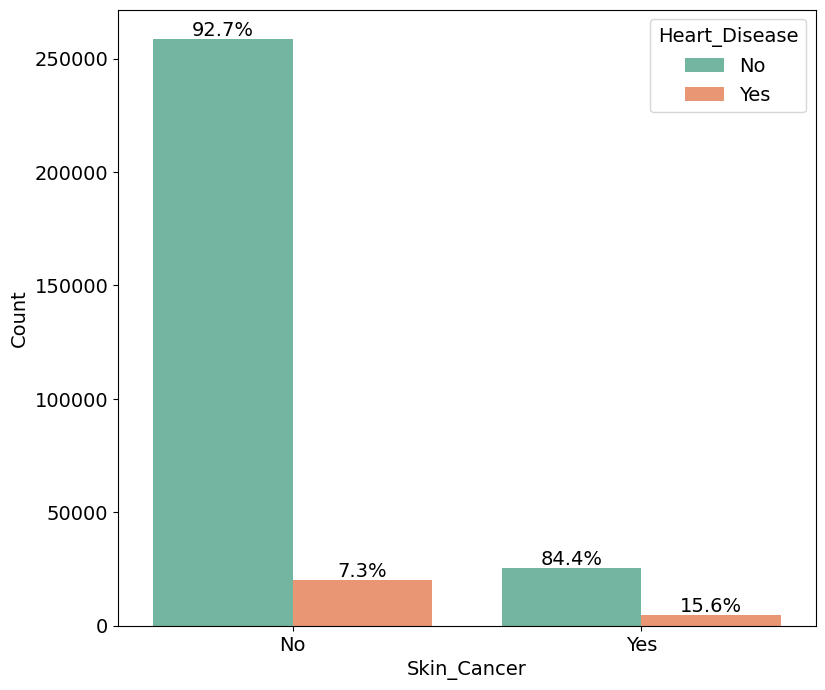

Smoking_History vs. Heart_Disease


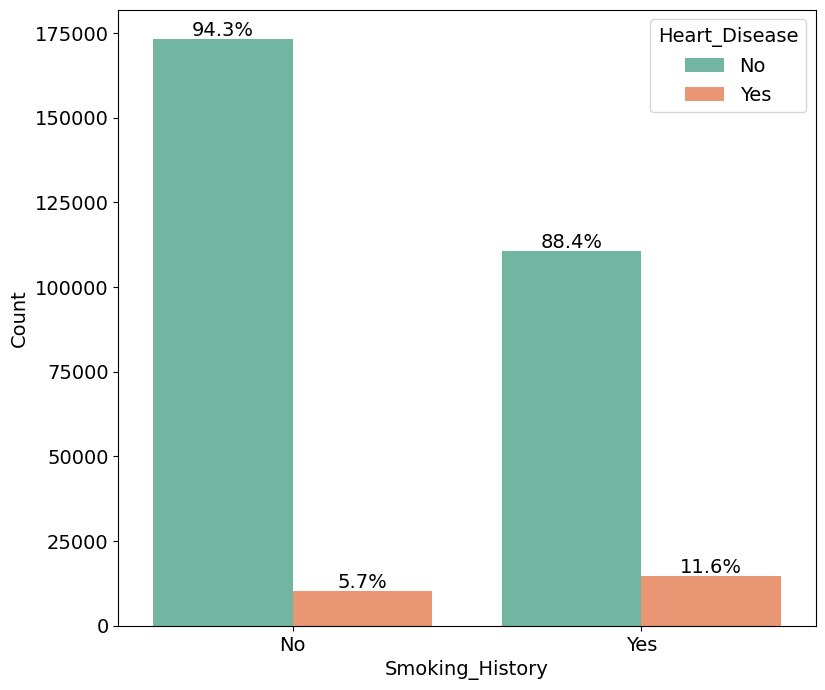

In [13]:
for i in categorical:
        if i == target:
            continue

        if df[i].nunique() > 15:
            print(f'column {i} has many unique values n = {df[i].nunique()} and will not be plotted')
            print('=======================================================')
            continue

        if i in df.columns:
            print(f'{i} vs. {target}')
            eda_bivariate_categorical(df,i,target)
            print('=======================================================')

Alcohol_Consumption vs. Heart_Disease


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

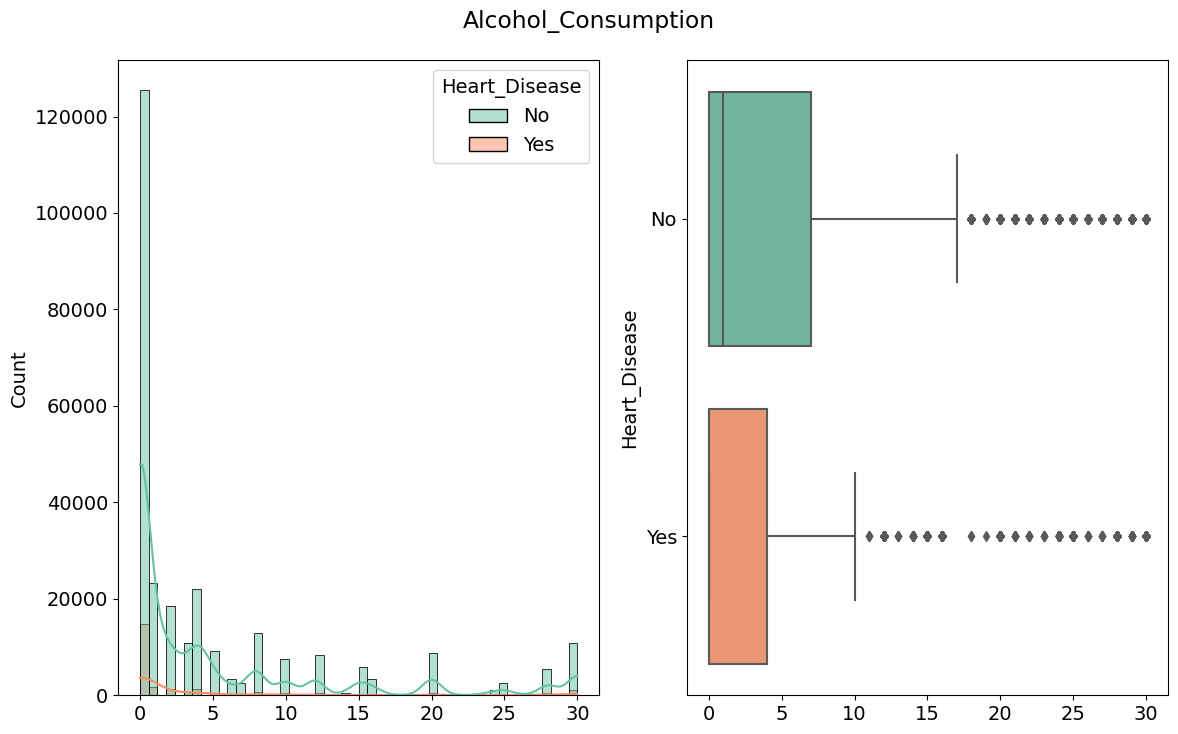

BMI vs. Heart_Disease


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

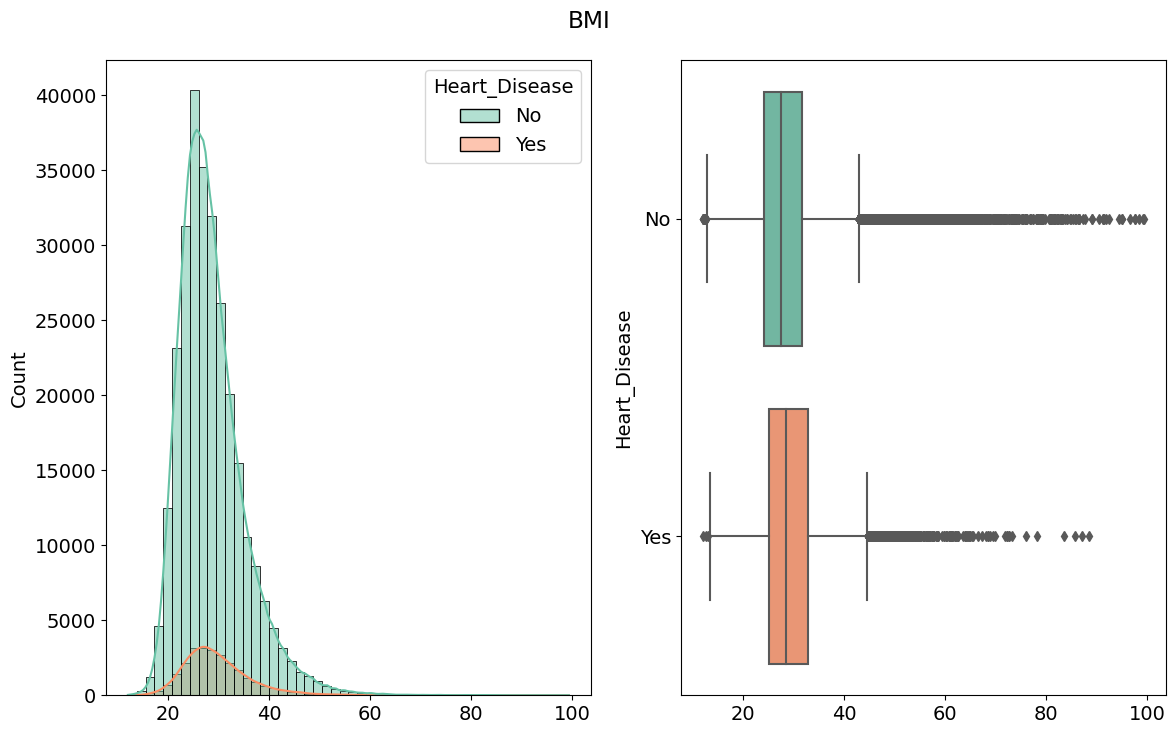

FriedPotato_Consumption vs. Heart_Disease


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

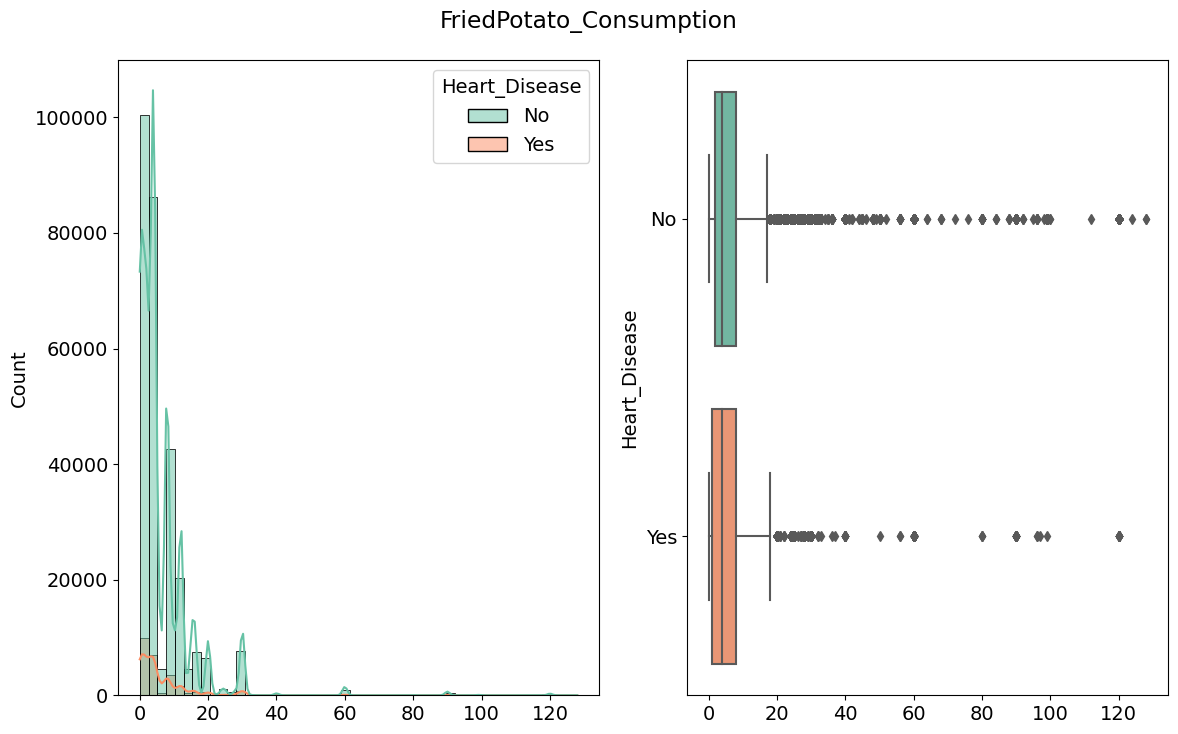

Fruit_Consumption vs. Heart_Disease


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

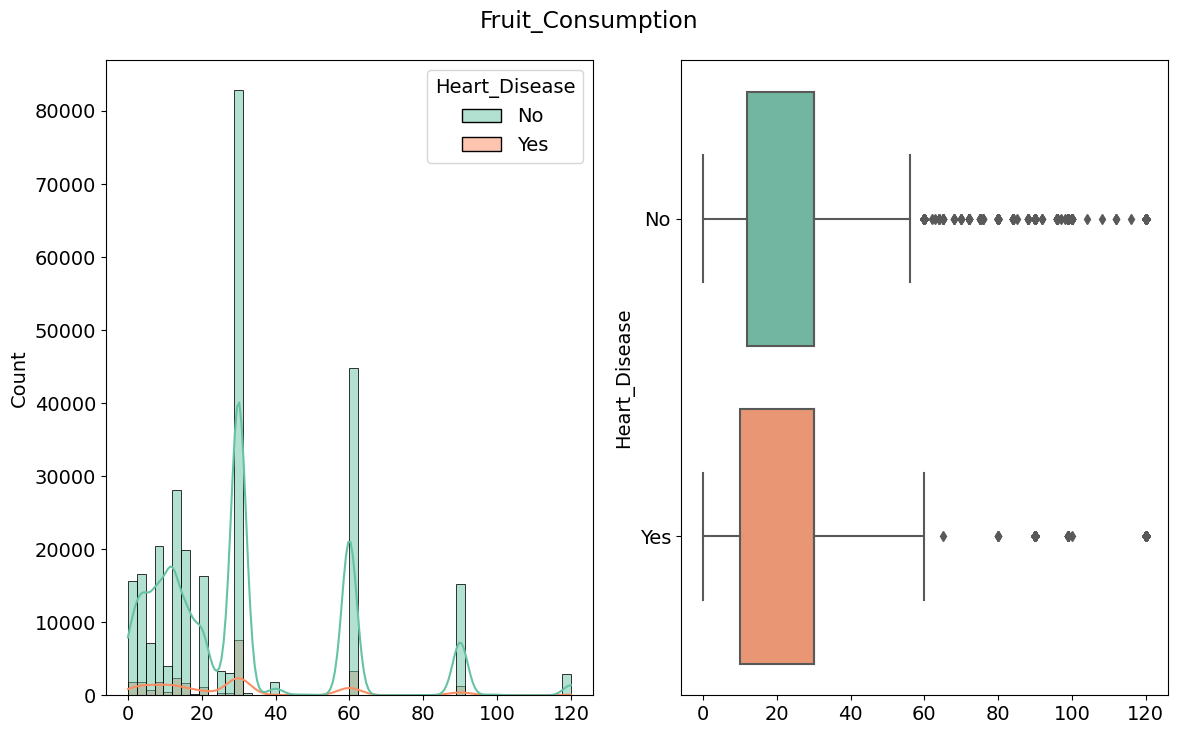

Green_Vegetables_Consumption vs. Heart_Disease


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

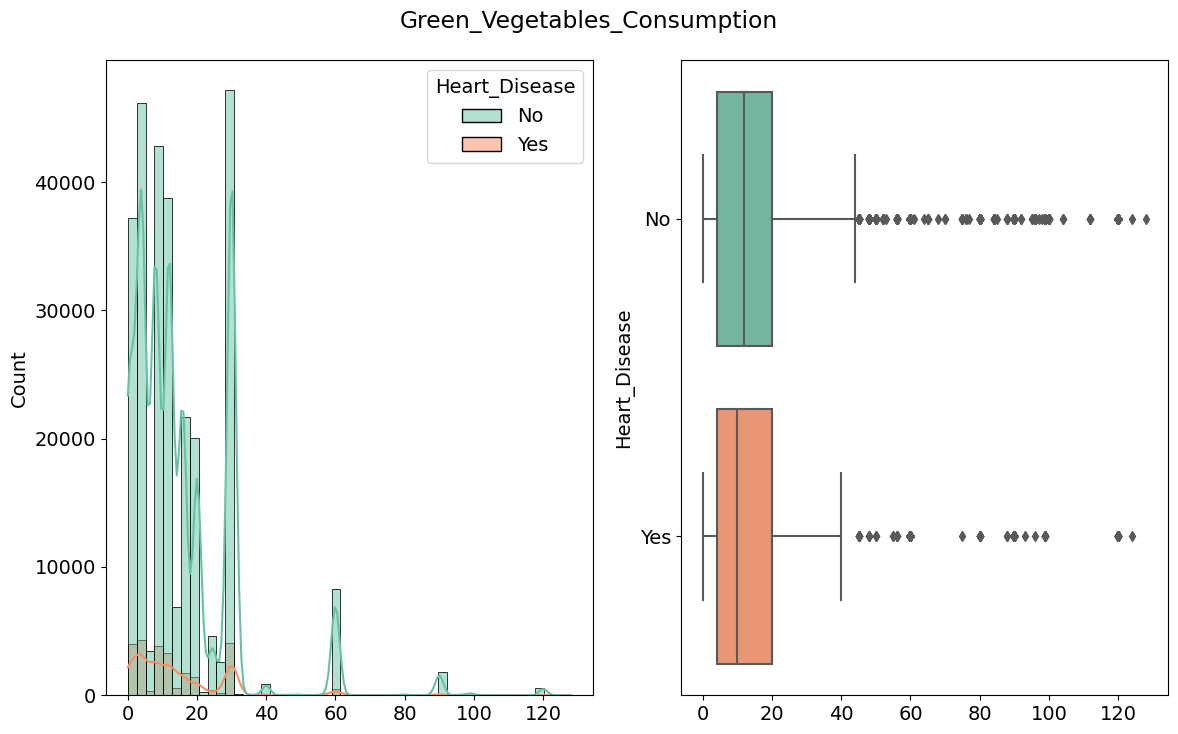

Height_(cm) vs. Heart_Disease


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

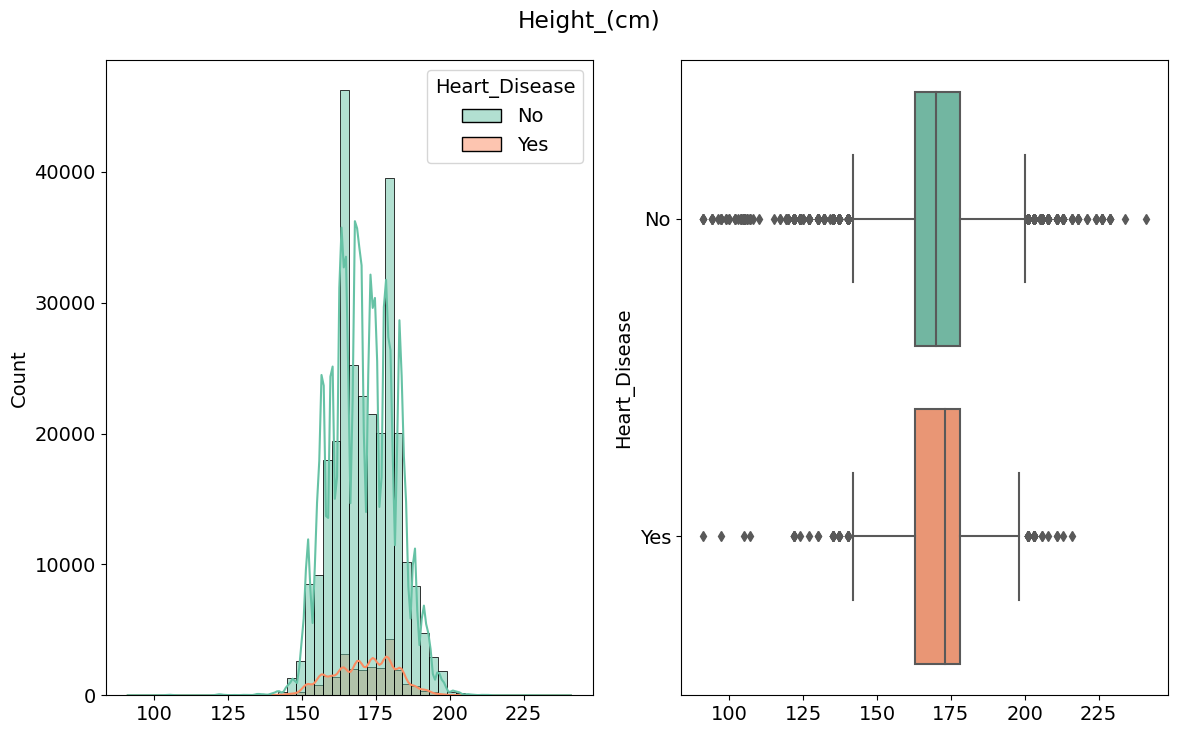

Weight_(kg) vs. Heart_Disease


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

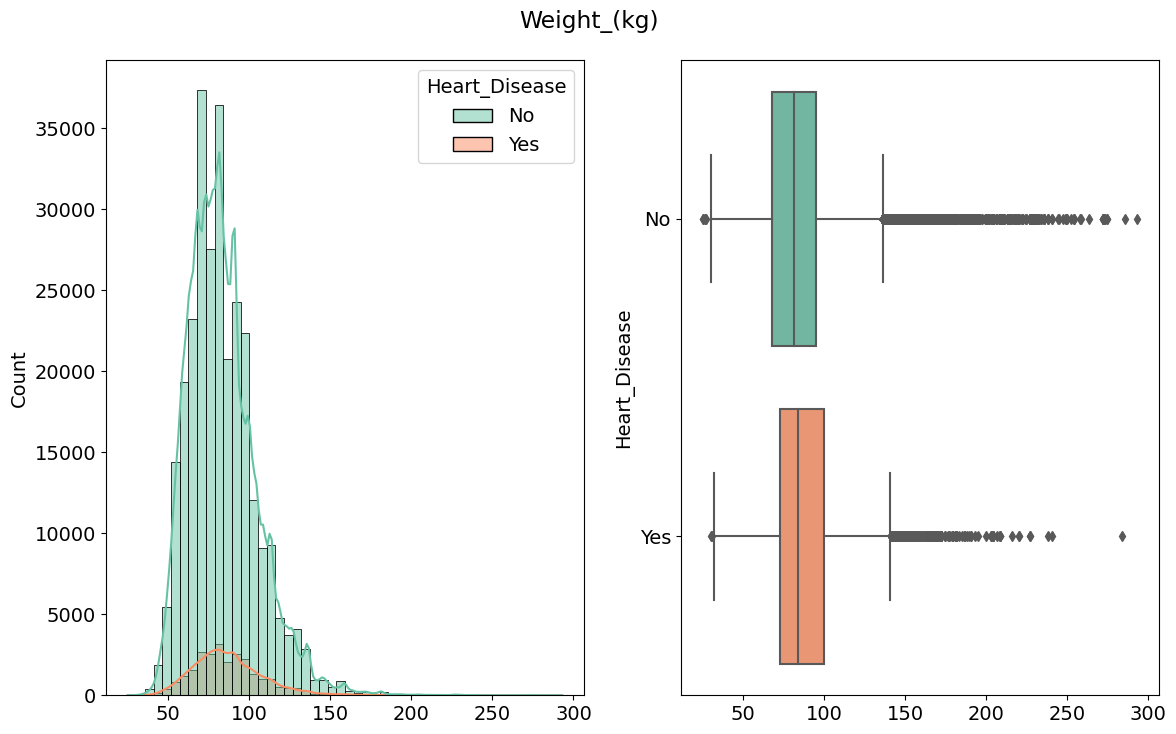

In [14]:
for i in numerical:
        if i == target:
            continue

        if i in df.columns:
            print(f'{i} vs. {target}')
            eda_bivariate_numerical(
                    data = df,
                    column = i,
                    target = target,
                    color = 'Set2',
                    figsize=(12,7.5),
                    val=0)
            print('=======================================================')

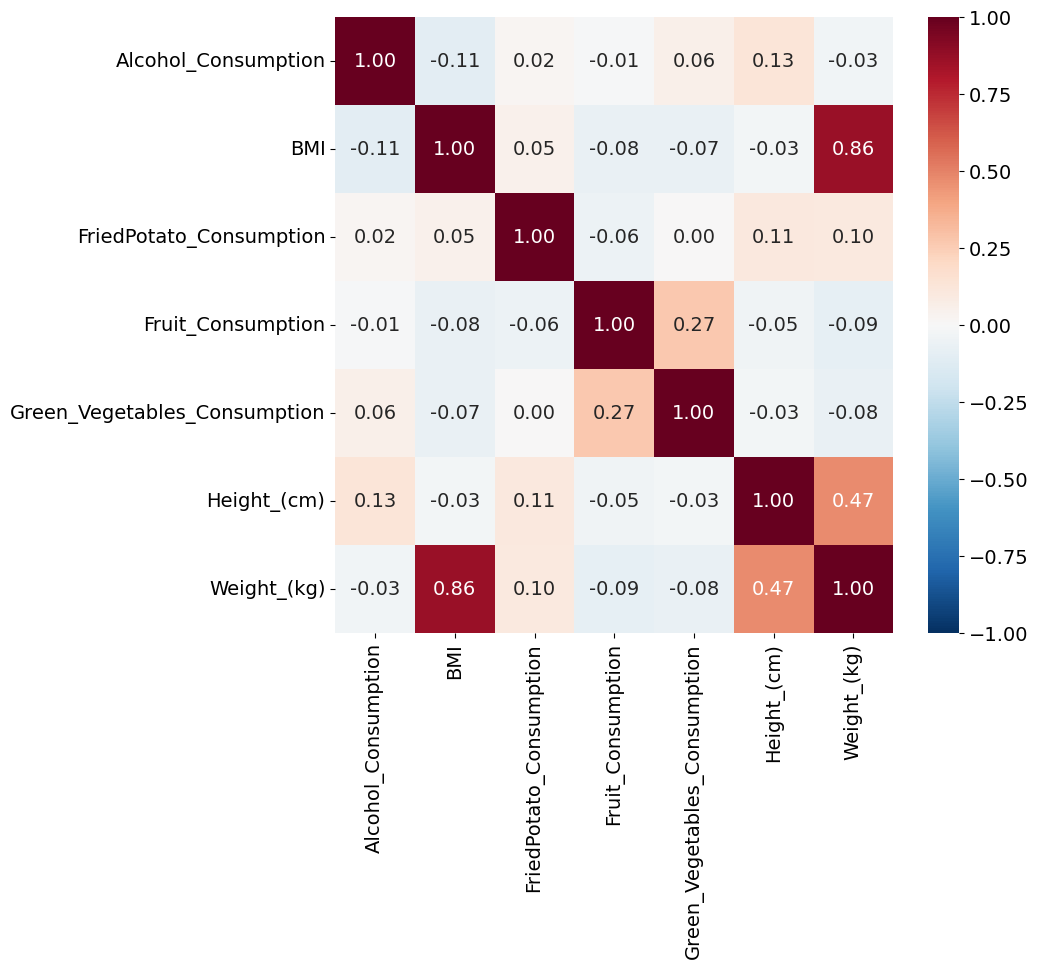

In [15]:
## Plotting the correlation matrix
correlation_matrix = df[numerical].corr()
plt.figure(figsize=(9,8))

## use mask to cover the upper diagonal in the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix,
            cmap='RdBu_r',
            # cmap='RdYlGn',
            annot=True,
            # Masking the diagonal
            # mask=mask,
            fmt='.2f',
            vmin=-1, vmax=1)

## Saving the figure
# plt.savefig("latex2.pdf")

plt.show()

# Preprocess


In [16]:
df['Heart_Disease'] = df['Heart_Disease'].map({'No':0,'Yes':1})
print('')
print(df['Heart_Disease'].value_counts())


Heart_Disease
0    283883
1     24971
Name: count, dtype: int64


In [17]:
from sklearn.model_selection import train_test_split

train,test = train_test_split(df, test_size=0.2,random_state=22,stratify=df['Heart_Disease'])

print(train.shape)
print(test.shape)

(247083, 19)
(61771, 19)


In [18]:
yes = train['Heart_Disease'].value_counts()[0]/len(train['Heart_Disease'])*100
no = train['Heart_Disease'].value_counts()[1]/len(train['Heart_Disease'])*100
print('Train Set')
print(f'ratio of people with heart disease to total is {yes}')
print(f'ratio of people that dont have heart disease to total is {no}')
print('')

yes = test['Heart_Disease'].value_counts()[0]/len(test['Heart_Disease'])*100
no = test['Heart_Disease'].value_counts()[1]/len(test['Heart_Disease'])*100
print('Test Set')
print(f'ratio of people with heart disease to total is {yes}')
print(f'ratio of people that dont have heart disease to total is {no}')

Train Set
ratio of people with heart disease to total is 91.91486261701533
ratio of people that dont have heart disease to total is 8.085137382984666

Test Set
ratio of people with heart disease to total is 91.91530005989866
ratio of people that dont have heart disease to total is 8.084699940101341


In [19]:
## Splitting the X and y variables in the train set
X_train = train.drop("Heart_Disease", axis=1)
y_train = train["Heart_Disease"].copy()

## Splitting the X and y variables in the test set
X_test = test.drop("Heart_Disease", axis=1)
y_test = test["Heart_Disease"].copy()

In [20]:
X_train.nunique()

General_Health                     5
Checkup                            5
Exercise                           2
Skin_Cancer                        2
Other_Cancer                       2
Depression                         2
Diabetes                           4
Arthritis                          2
Sex                                2
Age_Category                      13
Height_(cm)                       98
Weight_(kg)                      502
BMI                             3502
Smoking_History                    2
Alcohol_Consumption               31
Fruit_Consumption                 73
Green_Vegetables_Consumption      73
FriedPotato_Consumption           67
dtype: int64

In [21]:
cat_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore',drop='first'))

In [22]:
num_pipeline = make_pipeline(
                             FunctionTransformer(np.log1p,feature_names_out='one-to-one'),
                             StandardScaler()
                            )   

In [23]:
## Age Category Pipeline
agecat_pipeline = make_pipeline(
        OrdinalEncoder()
)

## General Health Pipeline
genhealth_pipeline = make_pipeline(
        OrdinalEncoder(categories=[['Poor','Fair','Good','Very Good','Excellent']])
)

## Checkup Pipeline
checkup_pipeline = make_pipeline(
        OrdinalEncoder(categories=[['Within the past year','Within the past 2 years','Within the past 5 years','5 or more years ago','Never']])
)

In [24]:
num_pipe_col = numerical

cat_pipe_col = ['Arthritis', 'Depression', 'Diabetes',
       'Exercise', 'Other_Cancer', 'Sex',
       'Skin_Cancer', 'Smoking_History']

In [25]:
preprocessing = ColumnTransformer([
    ('Categorical', cat_pipeline,   cat_pipe_col),
    ('Age_Category',agecat_pipeline,['Age_Category']),
    ('Checkup',checkup_pipeline,['Checkup']),
    ('Gen_health',genhealth_pipeline,['General_Health']),
    ('Numerical',   num_pipeline,  num_pipe_col),
],remainder='passthrough')
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('Categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['Arthritis', 'Depression', 'Diabetes',
                                  'Exercise', 'Other_Cancer', 'Sex',
                                  'Skin_Cancer', 'Smoking_History']),
                                ('Age_Category',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 ['Age_Category']),...
                                                                              'Excellent']]))]),
                                 ['General_Health']),
                                ('Numerical',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Alcohol_Consumption', 'BMI', 'FriedPotato_Consumption',
       'Fruit_Consumption', 'Green_Vegetables_Consumption', 'Height_(cm)',
       'Weight_(kg)'],
      dtype='object'))])

In [26]:
## Using preprocessing pipeline
print('Shape before the preprocessing:')
print(X_train.shape)

train_preprocessed = preprocessing.fit_transform(X_train)

print('Shape after the preprocessing:')
print(train_preprocessed.shape)

Shape before the preprocessing:
(247083, 18)
Shape after the preprocessing:
(247083, 20)


In [27]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=22)

In [28]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.linear_model import PassiveAggressiveClassifier, Perceptron, LogisticRegression, SGDClassifier, RidgeClassifier, RidgeClassifierCV
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [ ]:
models_w = {
    'BernoulliNB': BernoulliNB(),
    'PassiveAggressiveClassifier': PassiveAggressiveClassifier(random_state=22),
    'SVC': SVC(probability=True, random_state=22),
    'Perceptron': Perceptron(max_iter=1000, random_state=22),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=22),
    'LogisticRegression': LogisticRegression(max_iter=10000, random_state=22),
    'SGDClassifier': SGDClassifier(random_state=22),
    'ExtraTreeClassifier': ExtraTreeClassifier(random_state=22),
    'CalibratedClassifierCV': CalibratedClassifierCV(),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=22),
    'LGBMClassifier': LGBMClassifier(random_state=22),
    'GaussianNB': GaussianNB(),
    'ExtraTreesClassifier': ExtraTreesClassifier(n_estimators=100, random_state=22),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(),
    'LinearSVC': LinearSVC(max_iter=10000, random_state=22),
    'BaggingClassifier': BaggingClassifier(random_state=22),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=22),
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(),
    'NearestCentroid': NearestCentroid(),
    'NuSVC': NuSVC(probability=True, random_state=22),
    'RidgeClassifier': RidgeClassifier(random_state=22),
    'RidgeClassifierCV': RidgeClassifierCV(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=22),
    'LabelSpreading': LabelSpreading(),
    'LabelPropagation': LabelPropagation(),
    'DummyClassifier': DummyClassifier(strategy='most_frequent', random_state=22)
}


scores_dict = {}

report_dict = {}

In [29]:
models = {
    'Logistic_Regression':LogisticRegression(max_iter=10000,random_state=22),
    'Decision Tree':DecisionTreeClassifier(random_state=22),
    'Random_Forest':RandomForestClassifier(n_estimators=100,random_state=22),
    'K-Nearest_Neighbor':KNeighborsClassifier(),
    'GaussianNB':GaussianNB(),
}

scores_dict = {}

report_dict = {}

In [28]:
for model_name,model in models.items():
    model_pipeline = make_pipeline(preprocessing,
                              SMOTE(random_state=22),
                              model  
                                )
    scores = cross_val_score(model_pipeline, 
                            X_train, 
                            y_train, 
                            scoring='f1', 
                            cv=kf,
                            # verbose=1,
                            n_jobs=-1,
                            )
    model_score_mean = np.mean(scores)
    scores_dict[model_name] = model_score_mean
    print('------------------------------------------------------------')
    print(f'The score for {model_name} is {model_score_mean}')

    ## fitting the pipeline for classification report
    model_pipeline.fit(X_train,y_train)

    prediction = model_pipeline.predict(X_train)

    report = classification_report(y_train, prediction, output_dict=True)
    report_dict[model_name] = report
    print('')
    print(f'This is the classification report for {model_name}:')
    report_df = pd.DataFrame(report).T
    print(report_df)
    print('------------------------------------------------------------')

------------------------------------------------------------
The score for Logistic_Regression is 0.3256700726608769

This is the classification report for Logistic_Regression:
              precision    recall  f1-score        support
0              0.975137  0.731711  0.836066  227106.000000
1              0.205295  0.787906  0.325721   19977.000000
accuracy       0.736255  0.736255  0.736255       0.736255
macro avg      0.590216  0.759809  0.580894  247083.000000
weighted avg   0.912894  0.736255  0.794804  247083.000000
------------------------------------------------------------
------------------------------------------------------------
The score for Decision Tree is 0.22236536988625638

This is the classification report for Decision Tree:
              precision    recall  f1-score        support
0              0.999982  1.000000  0.999991  227106.000000
1              1.000000  0.999800  0.999900   19977.000000
accuracy       0.999984  0.999984  0.999984       0.999984
macro 

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


------------------------------------------------------------
The score for Random_Forest is 0.17830046073657052

This is the classification report for Random_Forest:
              precision    recall  f1-score        support
0              0.999974  0.999996  0.999985  227106.000000
1              0.999950  0.999700  0.999825   19977.000000
accuracy       0.999972  0.999972  0.999972       0.999972
macro avg      0.999962  0.999848  0.999905  247083.000000
weighted avg   0.999972  0.999972  0.999972  247083.000000
------------------------------------------------------------
------------------------------------------------------------
The score for K-Nearest_Neighbor is 0.2735006193889529

This is the classification report for K-Nearest_Neighbor:
              precision    recall  f1-score        support
0              0.999984  0.840867  0.913549  227106.000000
1              0.355954  0.999850  0.525003   19977.000000
accuracy       0.853721  0.853721  0.853721       0.853721
macro av

In [30]:
import pickle

# Assuming you've already trained your model pipeline with the Random Forest
model_name = 'Random_Forest'
model_pipeline = make_pipeline(preprocessing,
                                SMOTE(random_state=22),
                                models[model_name]  
                               )

# Fit the model pipeline
model_pipeline.fit(X_train, y_train)
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(model_pipeline, file)